In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input,LSTM, Dense, Embedding, Attention
from keras.layers import TimeDistributed, RepeatVector,Bidirectional
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
import re
import string
from unicodedata import normalize

In [2]:
!unzip -q /content/drive/MyDrive/archive.zip
!ls -lrt
!pwd

total 12216
-rw-r--r-- 1 root root 12497909 Apr  8  2020 eng_-french.csv
drwxr-xr-x 1 root root     4096 Nov 14 14:23 sample_data
drwx------ 6 root root     4096 Nov 16 13:52 drive
/content


In [3]:
def load_dataset(filepath):
    df = pd.read_csv(filepath,encoding='utf-8')
    print("Number of records:",len(df))
    return df

df = load_dataset(r'/content/eng_-french.csv')
df.head()

Number of records: 175621


,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
def preprocess_text(text):
    text = normalize('NFD',text).encode("ascii","ignore")
    text = text.decode("UTF-8")
    text = str(text)
    text = text.lower()
    text = text.translate(str.maketrans('','',string.punctuation))
    re_print = re.compile('[^%s]'% re.escape(string.printable))
    text = re_print.sub('',text)
    text = re.sub(r'[\d]+','',text)
    text = ' '.join(text.split())
    return text

In [5]:
df_copy = df.copy()
df_copy['English words/sentences'] = df_copy.loc[:,'English words/sentences'].apply(
    lambda x:preprocess_text(x))
df_copy['French words/sentences'] = df_copy.loc[:,'French words/sentences'].apply(
    lambda x:preprocess_text(x))
df_copy.head()

,English words/sentences,French words/sentences
0,hi,salut
1,run,cours
2,run,courez
3,who,qui
4,wow,ca alors


In [6]:
def tokenize(text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    return tokenizer

eng_tokenizer = tokenize(df_copy['English words/sentences'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

fr_tokenizer = tokenize(df_copy['French words/sentences'])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

seq_eng = eng_tokenizer.texts_to_sequences(df_copy['English words/sentences'])
seq_fr = fr_tokenizer.texts_to_sequences(df_copy['French words/sentences'])

max_length = max([len(seq) for seq in seq_eng + seq_fr])
seq_eng_final = pad_sequences(seq_eng,maxlen=max_length,padding="post")
seq_fr_final = pad_sequences(seq_fr,maxlen=max_length,padding="post")

print("English Vocab Size:",eng_vocab_size)
print("French Vocab Size:",fr_vocab_size)
print("Maximum length of sequences:",max_length)

English Vocab Size: 14407
French Vocab Size: 28133
Maximum length of sequences: 55


In [7]:
X_train,X_test,y_train,y_test = train_test_split(seq_eng_final,
                                                 seq_fr_final,
                                                 test_size=0.2,
                                                 shuffle=True,
                                                 random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((140496, 55), (35125, 55), (140496, 55), (35125, 55))

In [8]:
vector_length = 100
enc_inputs = Input(shape=(max_length,))
enc_embedding = Embedding(input_dim=eng_vocab_size,output_dim=vector_length)(enc_inputs)
enc_LSTM = LSTM(256,return_state=True)
enc_output,h,c = enc_LSTM(enc_embedding)
enc_states = [h,c]

dec_inputs = Input(shape=(max_length,))
dec_embedding = Embedding(input_dim=fr_vocab_size,output_dim=vector_length)(dec_inputs)
dec_LSTM = LSTM(256,return_sequences=True,return_state=True)
dec_output,_,_ = dec_LSTM(dec_embedding,initial_state=enc_states)


dec_dense = Dense(fr_vocab_size,activation="softmax")
output = dec_dense(dec_output)
model = Model([enc_inputs,dec_inputs],output)
model.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [9]:
model.fit([X_train,X_train],y_train,epochs=2,validation_data=([X_test,X_test],y_test))

Epoch 1/2
4391/4391 [==============================] - 425s 95ms/step - loss: 0.7469 - accuracy: 0.8987 - val_loss: 0.6045 - val_accuracy: 0.9079
Epoch 2/2
4391/4391 [==============================] - 368s 84ms/step - loss: 0.5363 - accuracy: 0.9123 - val_loss: 0.5115 - val_accuracy: 0.9141


In [10]:
vector_length = 100
model = Sequential()
model.add(Embedding(input_dim=eng_vocab_size,output_dim=vector_length,input_length=max_length,mask_zero=True))
model.add(Bidirectional(LSTM(256)))
model.add(RepeatVector(max_length))
model.add(LSTM(256,return_sequences=True))
model.add(TimeDistributed(Dense(fr_vocab_size,activation="softmax")))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 55, 100)           1440700   
                                                                 
 bidirectional (Bidirection  (None, 512)               731136    
 al)                                                             
                                                                 
 repeat_vector (RepeatVecto  (None, 55, 512)           0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 55, 256)           787456    
                                                                 
 time_distributed (TimeDist  (None, 55, 28133)         7230181   
 ributed)                                                        
                                                        

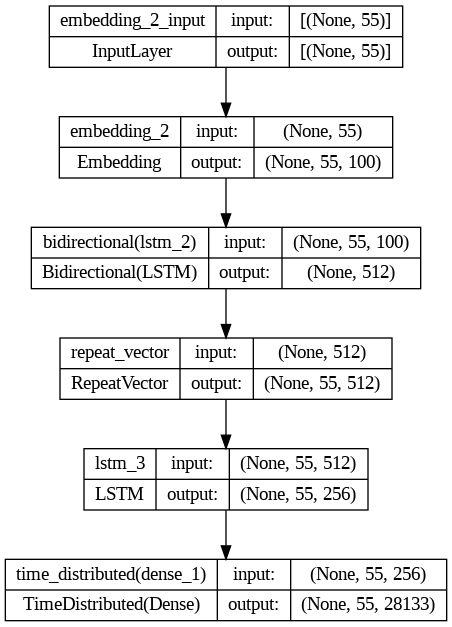

In [11]:
plot_model(model,to_file="model.png",show_shapes=True)

In [12]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
4391/4391 [==============================] - 527s 117ms/step - loss: 0.8302 - accuracy: 0.8903 - val_loss: 0.7109 - val_accuracy: 0.8988
Epoch 2/5
4391/4391 [==============================] - 529s 120ms/step - loss: 0.6426 - accuracy: 0.9039 - val_loss: 0.5920 - val_accuracy: 0.9082
Epoch 3/5
4391/4391 [==============================] - 528s 120ms/step - loss: 0.5262 - accuracy: 0.9123 - val_loss: 0.5091 - val_accuracy: 0.9141
Epoch 4/5
4391/4391 [==============================] - 528s 120ms/step - loss: 0.4390 - accuracy: 0.9184 - val_loss: 0.4575 - val_accuracy: 0.9185
Epoch 5/5
4391/4391 [==============================] - 529s 120ms/step - loss: 0.3772 - accuracy: 0.9234 - val_loss: 0.4246 - val_accuracy: 0.9217


In [13]:
def translation(input_sentence):
    input_sentence = preprocess_text(str(input_sentence))
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq_final = pad_sequences(input_seq,maxlen=max_length,padding="post")
    prediction = model.predict([input_seq_final])
    output_translation = np.argmax(prediction,axis=-1)

    output_sentence = []
    for i in output_translation[0]:
        if i in fr_tokenizer.index_word:
            output_sentence.append(fr_tokenizer.index_word[i])
        else:
            output_sentence.append(' ')
    return ' '.join(output_sentence)

input_sentence = "How are you?"
translated = translation(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translated: {translated}")

1/1 [==============================] - 3s 3s/step
Input: How are you?
Translated: comment etesvous                                                                                                          
